In [22]:
import cv2
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
# Load the pre-trained ESRGAN model
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.restoration import denoise_wavelet
from skimage.filters import threshold_sauvola


char_model2=load_model("/kaggle/input/language-classification-1/keras/default/3/best_model (2).keras")


📜 Final Manuscript Classification: sanskrit
🗳️ Votes Breakdown: {'sanskrit': 774, 'tamil': 39}


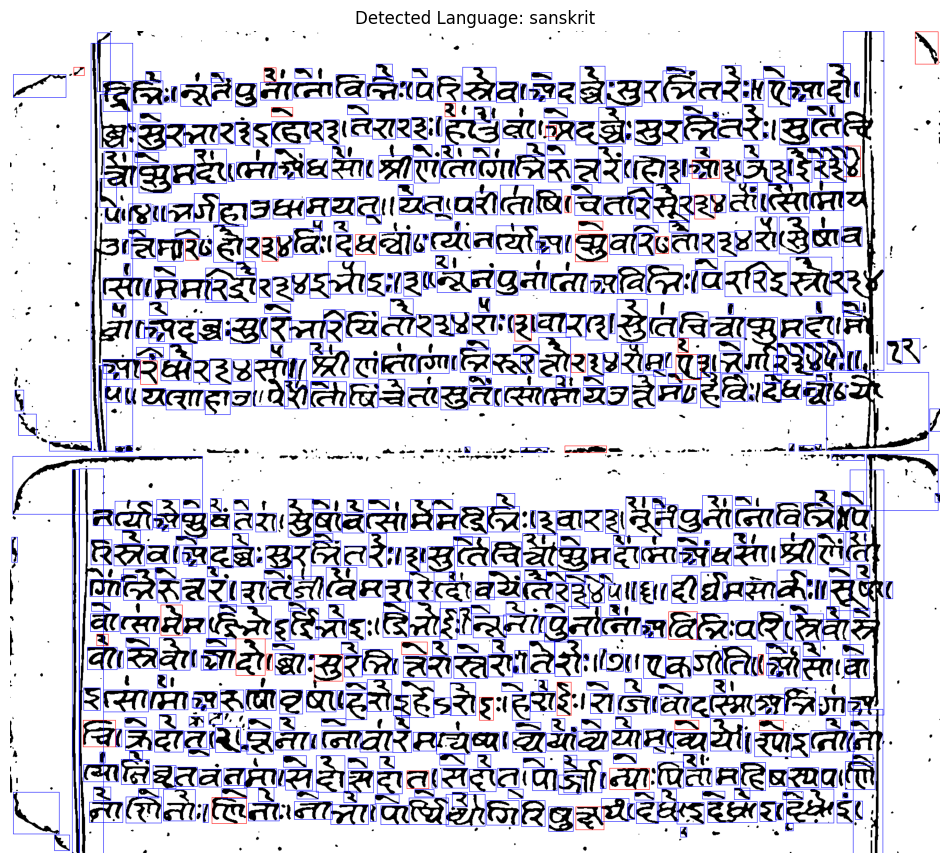

In [ ]:
import matplotlib.pyplot as plt

# Load model
classes = ["sanskrit", "tamil"]
votes = {"sanskrit": 0, "tamil": 0}

# Image path
manuscript_path = "/kaggle/input/testtt/8_median_filtered_output.png"

# Preprocessing for classification
def preprocess_word_image(word_img, img_height=64, img_width=192):
    resized = cv2.resize(word_img, (img_width, img_height))
    arr = img_to_array(resized) / 255.0
    arr = np.expand_dims(arr, axis=-1)
    arr = np.expand_dims(arr, axis=0)
    return arr

# Load image and prepare for segmentation
original_img = cv2.imread(manuscript_path)
gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours left to right (optional, for consistent order)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Process each word
for idx, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if w < 10 or h < 10:  # Ignore noise
        continue

    word_img = gray[y:y+h, x:x+w]
    word_input = preprocess_word_image(word_img)
    prediction = char_model2.predict(word_input)
    predicted_class = np.argmax(prediction)
    label = classes[predicted_class]
    votes[label] += 1

    # Draw bounding box with color based on prediction
    if label == "sanskrit":
        cv2.rectangle(original_img, (x, y), (x+w, y+h), (255, 0, 0), 1)  # Blue box for Sanskrit
    else:
        cv2.rectangle(original_img, (x, y), (x+w, y+h), (0, 0, 255), 1)  # Red box for Tamil

# Final classification
predicted_page_language = max(votes, key=votes.get)
print(f"📜 Final Manuscript Classification: {predicted_page_language}")
print(f"🗳️ Votes Breakdown: {votes}")

# Convert image to RGB for display in matplotlib
output_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display image with bounding boxes
plt.figure(figsize=(12, 12))
plt.imshow(output_img_rgb)
plt.title(f"Detected Language: {predicted_page_language}")
plt.axis('off')
plt.show()